# Bayesian Neural Networks (BNNs)

In this notebook a Bayesian Neural network is trained on the CFB data to take bridge parameter as input an predict the code compliance factors.

### Resources
Here you can find nice explanations: 

1. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

The following source was used as a stating point for the implementation:

2. https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825 

### Content
1. Data Import
2. Data Pre-processing
3. Setup and Train Model
4. Model Perfromance Evaluation
5. 1D Parameter Studies


In [1]:
#import necessary libraries
import json
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset




In [2]:
### Initialise Training study tracking dict
# initialise whole dict (only run once per study)
#only has to be run once when a new dict should be created
# eval_dict={}

In [3]:
# load_evaluation dict

dict_name='Studie_1_Sophia'
with open('trainedModels\\{}.json'.format(dict_name), 'r') as file:
    eval_dict = json.load(file)

In [4]:
eval_dict

{'1001_no0_3_20_rmse_500_1': {'model_settings': {'batch': 1001,
   'filtered': 'without zero etas',
   'total_data_size': 6010,
   'test_split': 0.2,
   'val_split': 0.2,
   'layers': 3,
   'width': [16, 20, 20],
   'loss': 'cost',
   'kl_weight': 0.001,
   'learning_rate': 0.001,
   'epochs': 500,
   'batch_size': 32},
  'training_set_performance': {'rmse_all': 3.734505750658081,
   'mape_all': 4949.260817740838,
   'rmse_crit1': 1.5986372748420694,
   'mape_crit1': 136.2501117256553,
   'rmse_crit2': 1.551925625707856,
   'mape_crit2': 54.37055464061095,
   'rmse_crit3': 1.9535538470429348,
   'mape_crit3': 27.412232378918212,
   'rmse_crit4': 5.27106323668057,
   'mape_crit4': 13.239928741886342,
   'custom': 0.3816503999787,
   'ECE': 0.3769942797711909,
   'TCE': 37.699427977119086,
   'CB': 37.699427977119086},
  'validation_set_performance': {'rmse_all': 5.9319562964731,
   'mape_all': 71.94231778645445,
   'rmse_crit1': 1.9021277031019168,
   'mape_crit1': 149.21109923366316,
 

## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [5]:
####### load values #######

data_batch=1001
train_df = pd.read_csv("trainingData/{}_CFB_xy_train.csv".format(data_batch))
val_df = pd.read_csv("trainingData/{}_CFB_xy_validation.csv".format(data_batch))
test_df = pd.read_csv("trainingData/{}_CFB_xy_test.csv".format(data_batch))

# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select target(s)
y_names=['eta_min_c']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (3846, 16) (3846, 1)
Validation Dataset:  (962, 16) (962, 1)
Test Dataset:  (1202, 16) (1202, 1)
Total Dataset:  (6010, 16)


## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in trianing and test set
- transform data to same range with MinMaxScaler
- transform scaled data to troch tensors

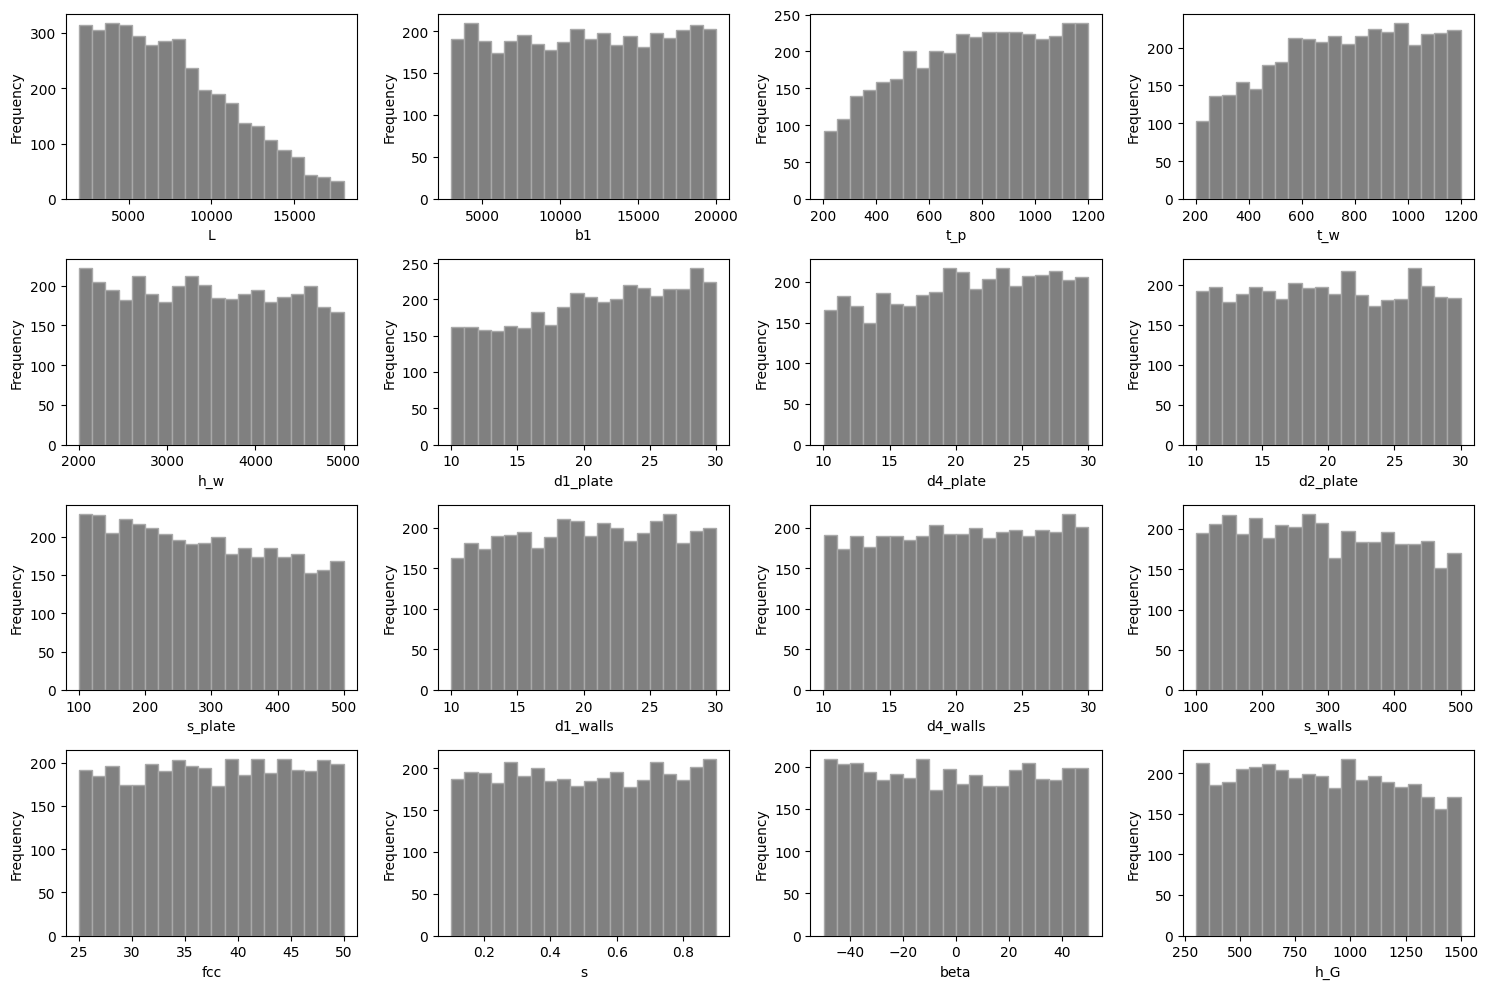

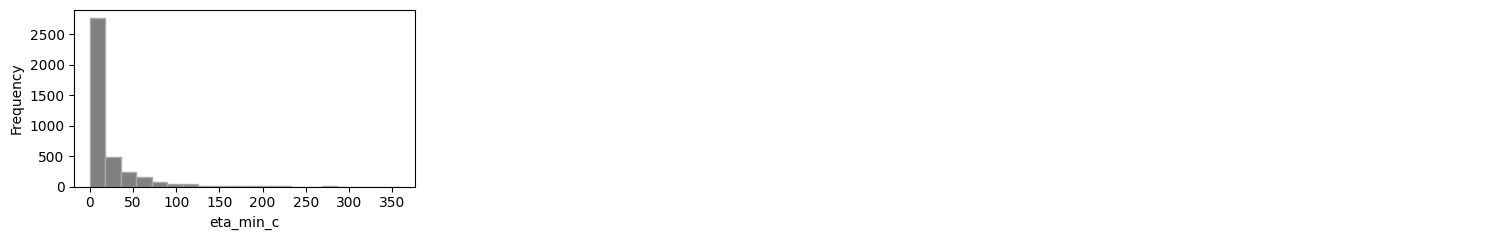

In [6]:
from plotting import hist_matrix
hist_matrix(x_train_df)
hist_matrix(y_train_df)

In [7]:
###### Scaling of data ######

# INPUT we scale to a range 0,1
# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
# Note: MinMaxScaler is sufficient as our data is uniformily distributed for the case when we have non-uniform distirbuted data (as sampled with )

#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000
mean,0.350768,0.505354,0.557761,0.547565,0.488458,0.536404,0.521731,0.500145,0.468689,0.510742,0.509276,0.482430,0.505470,0.502159,0.496298,0.484848
std,0.237993,0.290965,0.271769,0.273215,0.288443,0.286398,0.285098,0.287962,0.287903,0.285046,0.289035,0.285236,0.288554,0.291400,0.292261,0.284170
min,0.000000,0.000839,0.000000,0.000760,0.000059,0.000000,0.000000,0.000117,0.000000,0.000070,0.000000,0.000493,0.000090,0.000000,0.000372,0.000000
25%,0.153476,0.253187,0.336836,0.330400,0.238056,0.299895,0.283016,0.251506,0.216367,0.265013,0.262962,0.235942,0.261644,0.247011,0.241140,0.240921
50%,0.317211,0.507889,0.575515,0.559258,0.482384,0.553328,0.531550,0.499293,0.453527,0.512516,0.513107,0.470530,0.507422,0.501717,0.490890,0.479285
75%,0.515312,0.760304,0.788150,0.778639,0.738438,0.783063,0.766318,0.752287,0.714387,0.760302,0.759400,0.727362,0.756341,0.758906,0.752153,0.723903
max,0.999013,1.000000,0.999788,0.999749,0.999908,0.999944,0.999559,1.000000,0.999872,1.000000,1.000000,0.999957,1.000000,0.999821,1.000000,0.999692


In [8]:
# Note instead of scaling the data here I inlcuded a mean squared log error loss in my training which has the same effect but no need for preprocessing and postprocing of training input and prediction output
# ###### Scaling of data ######

# # Y (Output) we scale with log(y)
# #m.log(y_train_np)

# # Applying y_trans=log_e(y+1) function/ transformation
# y_train_transf_np = np.log(y_train_np + 1) # log_e
# y_train_transf_df=pd.DataFrame(y_train_transf_np, columns=y_names)

# y_val_transf_np = np.log(y_val_np + 1) # log_e
# y_val_transf_df=pd.DataFrame(y_val_transf_np, columns=y_names)


# hist_matrix(y_train_transf_df)


# ##### convert to troch tensors ######

# # convert data to toch tensors (as needed format for BNN model)
# x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
# y_train_transf_tensor=torch.tensor(y_train_transf_df.values, dtype=torch.float32)

# x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
# y_val_transf_tensor=torch.tensor(y_val_transf_df.values, dtype=torch.float32)

In [9]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Trianing Loop
- Plot loss developement during trianing
- save trained model

In [84]:
# define NN architecture
layers=3 # define manually
width=[16,20,20] # define manually
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
    nn.ReLU()
)


#initialize error tracking lists
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

weighted_mse_list = []
weighted_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]

mape_list=[]
mape_val_list=[]

custom_loss_list = []
custom_loss_val_list = []


In [85]:
##### Losses ######

#get loss functions
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# get mse loss
mse_loss = nn.MSELoss()

#import losses
from MLmodel import  weighted_mse_loss, msle_loss, mape_loss,custom_loss





In [86]:
### Define other hyperparameters

# define kl weight for weighing of kl_loss in total loss function
# Note: depending which loss function are used different kl_weights should be chosen...msle is of a multiple magnitude smaller than the mse, so the kl_weight hast to also be adapter when we use that weight.
# Note: with mse loss 0.01, with msle loss 0.0001 [0.001]
#TO Test: [0.01,0.001, 0.0001]
kl_weight = 0.00001

#get optimizer
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define epochs, and the training data, and the batch size
epochs = 500
batch_size = 32

In [87]:
### save model training settings to eval_dict

#define model name:
# name rule: batch_filter_modeldepth_width_lossfunction_epochs_iteration
#!!!!
model_name='1001_no0_3_20_log_500_4'  # define manually

# initialize model dict
eval_dict[model_name]={} 
eval_dict[model_name]['model_settings']={}
eval_dict[model_name]['training_set_performance']={}
eval_dict[model_name]['validation_set_performance']={}

# save model settings
eval_dict[model_name]['model_settings']['batch']=data_batch
eval_dict[model_name]['model_settings']['filtered']="without zero etas" # define manually
eval_dict[model_name]['model_settings']['total_data_size']=total_data_set_size
eval_dict[model_name]['model_settings']['test_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['val_split']=0.2 # define manually
eval_dict[model_name]['model_settings']['layers']=layers
eval_dict[model_name]['model_settings']['width']=width
#!!!!
eval_dict[model_name]['model_settings']['loss']='log' # define manually

eval_dict[model_name]['model_settings']['kl_weight']=kl_weight
eval_dict[model_name]['model_settings']['learning_rate']=learning_rate
eval_dict[model_name]['model_settings']['epochs']=epochs
eval_dict[model_name]['model_settings']['batch_size']=batch_size
eval_dict

{'1001_no0_3_20_rmse_500_1': {'model_settings': {'batch': 1001,
   'filtered': 'without zero etas',
   'total_data_size': 6010,
   'test_split': 0.2,
   'val_split': 0.2,
   'layers': 3,
   'width': [16, 20, 20],
   'loss': 'cost',
   'kl_weight': 0.001,
   'learning_rate': 0.001,
   'epochs': 500,
   'batch_size': 32},
  'training_set_performance': {'rmse_all': 3.734505750658081,
   'mape_all': 4949.260817740838,
   'rmse_crit1': 1.5986372748420694,
   'mape_crit1': 136.2501117256553,
   'rmse_crit2': 1.551925625707856,
   'mape_crit2': 54.37055464061095,
   'rmse_crit3': 1.9535538470429348,
   'mape_crit3': 27.412232378918212,
   'rmse_crit4': 5.27106323668057,
   'mape_crit4': 13.239928741886342,
   'custom': 0.3816503999787,
   'ECE': 0.3769942797711909,
   'TCE': 37.699427977119086,
   'CB': 37.699427977119086},
  'validation_set_performance': {'rmse_all': 5.9319562964731,
   'mape_all': 71.94231778645445,
   'rmse_crit1': 1.9021277031019168,
   'mape_crit1': 149.21109923366316,
 

In [88]:
### trianing loop 

# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_weighted_mse = []
    epoch_rmse = []
    epoch_kl = []
    epoch_mape = []
    epoch_custom = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle loss
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # weighted MSE loss
        weighted_mse = weighted_mse_loss(y_pred, y, importance_range=(0.1, 3), high_weight=100)
        epoch_weighted_mse.append(weighted_mse.item())
        # custom_mse_list.append(custom_mse.item())

        # mape
        mape= mape_loss(y_pred, y)
        epoch_mape.append(mape.item())


        # # Custom loss
        custom = custom_loss(y_pred, y, threshold=0.5, alpha=1, beta=1)
        epoch_custom.append(custom.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_weigthed_mse= weighted_mse + kl_weight*kl
        cost_mape = mape + kl_weight*kl
        cost_custom=custom + kl_weight*kl
        
        optimizer.zero_grad()
        #!!!!
        cost_log.backward() #Specify loss that should be used here
        #!!!!
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    weighted_mse_list.append(np.mean(epoch_weighted_mse))
    kl_list.append(np.mean(epoch_kl))
    mape_list.append(np.mean(epoch_mape))
    custom_loss_list.append(np.mean(epoch_custom))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # weighted MSE loss
        weighted_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        weighted_mse_val_list.append(weighted_mse_val.item())

        # mape loss
        mape_val = mape_loss(y_val_pred, y_val_tensor)
        mape_val_list.append(mape_val.item())

        # custom loss
        custom_val = custom_loss(y_val_pred, y_val_tensor, threshold=0.5, alpha=1, beta=1)
        custom_loss_val_list.append(custom_val.item())
        

    # verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
        else:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')


# OLD
#     # verbalise
#     if step % 50 == 0:
#         if with_stochasticPrediction:
#             print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#                 f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
#                 'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#                 f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
#         else: 
#             print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#                 f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
#                 'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#                 f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

    

print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
else:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')   


# print('Training is finished. The final losses:') 
# if with_stochasticPrediction:
#     print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#           f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
#           'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#           f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
# else:
#     print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#           f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
#           'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#           f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

Step 0, On Training Set: MSE: 378.55, MSLE: 0.42, KL: 1.08, RMSE: 19.46, Weighted MSE: 405.51, MAPE: 59.90, Custom Loss: 0.60; On Validation Set: Val MSE: 1081.97, Val MSLE: 0.44, Val RMSE: 32.89, Val Weighted MSE: 1086.41, Val MAPE: 145.31, Val Custom Loss: 0.78
Step 50, On Training Set: MSE: 15.03, MSLE: 0.02, KL: 10.31, RMSE: 3.88, Weighted MSE: 47.76, MAPE: 36.18, Custom Loss: 0.36; On Validation Set: Val MSE: 301.45, Val MSLE: 0.06, Val RMSE: 17.36, Val Weighted MSE: 345.07, Val MAPE: 154.29, Val Custom Loss: 0.76
Step 100, On Training Set: MSE: 178.01, MSLE: 0.11, KL: 19.62, RMSE: 13.34, Weighted MSE: 591.65, MAPE: 483.33, Custom Loss: 1.08; On Validation Set: Val MSE: 191.41, Val MSLE: 0.03, Val RMSE: 13.84, Val Weighted MSE: 198.09, Val MAPE: 65.52, Val Custom Loss: 0.37
Step 150, On Training Set: MSE: 190.51, MSLE: 0.03, KL: 27.66, RMSE: 13.80, Weighted MSE: 244.70, MAPE: 42.19, Custom Loss: 0.42; On Validation Set: Val MSE: 133.33, Val MSLE: 0.02, Val RMSE: 11.55, Val Weighte

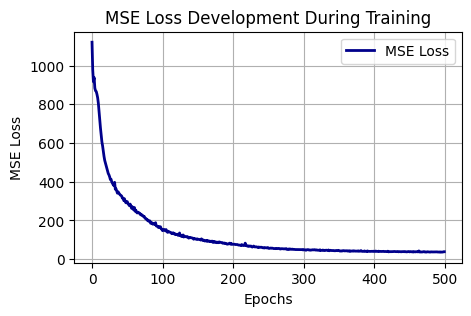

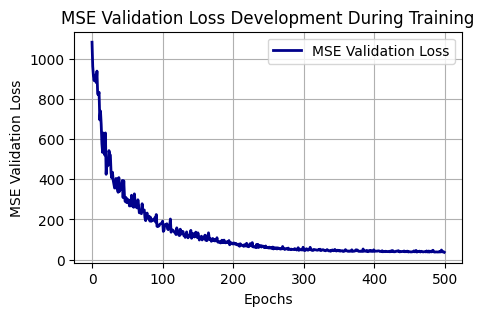

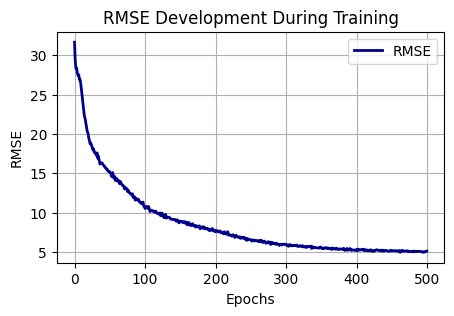

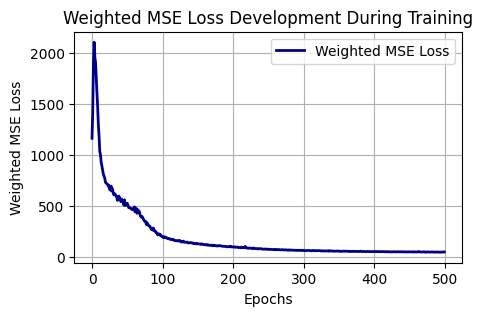

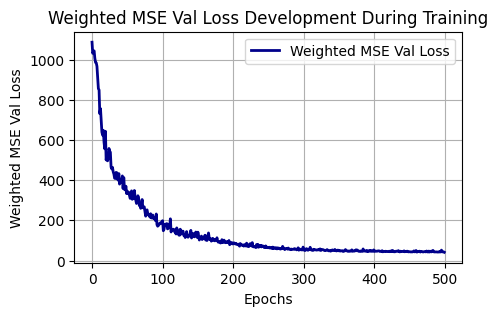

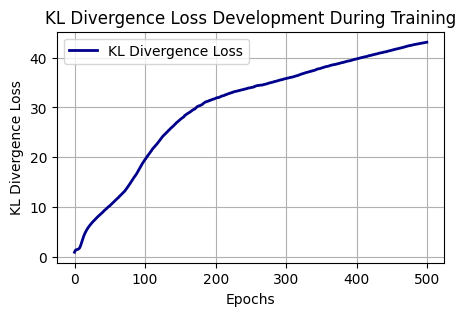

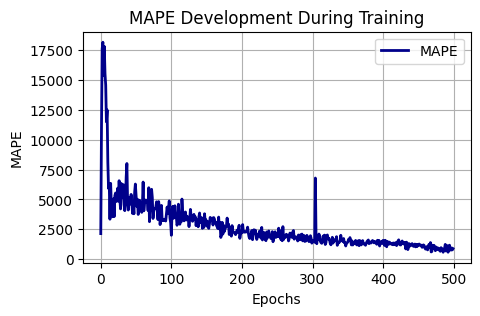

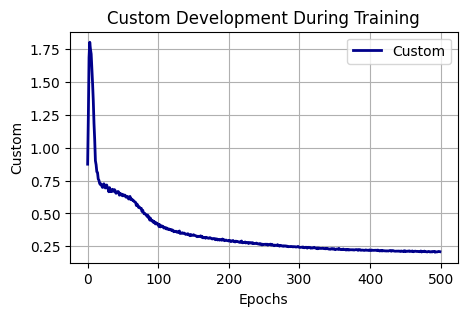

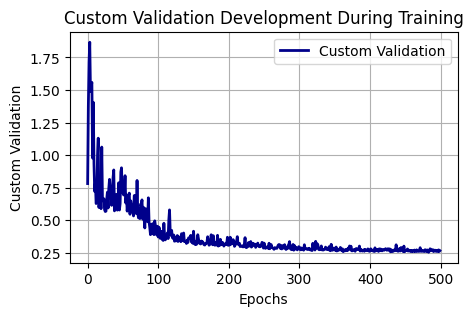

In [89]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, weighted_mse_list,weighted_mse_val_list, kl_list, mape_list, custom_loss_list,custom_loss_val_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, weighted_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Weighted MSE Loss','Weighted MSE Val Loss', 'KL Divergence Loss', 'MAPE', 'Custom', 'Custom Validation']
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name=model_name, figsize=(5, 3))

In [90]:
####### save model #######
# define model name

#saving the whole model
torch.save(model, 'trainedModels\\'+model_name+'.pth')

#saving just the weights and biases
#torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 4. Model evaluation
    


In [91]:
## load a model
#model_name=
model = torch.load('trainedModels\\'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (5): ReLU()
)

In [92]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

### On training data



In [93]:
# make predictions and caluclate mean 
##### make predictions ####3
# Define number of predictions
n_predictions = 1000
# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)

In [94]:
dict_name='training_set_performance'
eval_dict=evaluate_model_performance(y_true=y_train_np, y_pred=y_train_mean_pred_np,
                                      dict_name=dict_name, model_name=model_name, eval_dict=eval_dict)

In [95]:
# uncertanty evaluation

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#y_pred_mean=
#y_pred_std


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_train_mean_pred_np, y_train_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_train_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

#print(coverages)

from sklearn.metrics import mean_squared_error
# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
#print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
# print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
# print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][dict_name]['ECE']=ece
eval_dict[model_name][dict_name]['TCE']=tce
eval_dict[model_name][dict_name]['CB']=bias

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_35848\2916242262.py:19: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [96]:
#print perfromances on training set
eval_dict[model_name][dict_name]

{'rmse_all': 5.952508364352673,
 'mape_all': 958.5576269973243,
 'rmse_crit1': 0.7048426659695709,
 'mape_crit1': 53.74840285754235,
 'rmse_crit2': 0.77813447930421,
 'mape_crit2': 25.833175067692,
 'rmse_crit3': 1.3615696480995876,
 'mape_crit3': 18.276086631306157,
 'rmse_crit4': 8.962648027738698,
 'mape_crit4': 13.189473730871576,
 'custom': 0.20643574839582313,
 'ECE': 0.3950962038481539,
 'TCE': 39.50962038481539,
 'CB': 39.50962038481539}

### on validation set

In [97]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)


In [98]:
dict_name='validation_set_performance'
eval_dict=evaluate_model_performance(y_true=y_val_np, y_pred=y_val_mean_pred_np,
                                      dict_name=dict_name, model_name=model_name, eval_dict=eval_dict)

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_val_mean_pred_np, y_val_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_val_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

print(coverages)


# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][dict_name]['ECE']=ece
eval_dict[model_name][dict_name]['TCE']=tce
eval_dict[model_name][dict_name]['CB']=bias

[0.0, 0.0031185031185031187, 0.004158004158004158, 0.006237006237006237, 0.008316008316008316, 0.009355509355509356, 0.009355509355509356, 0.009355509355509356, 0.010395010395010396, 0.012474012474012475, 0.012474012474012475, 0.012474012474012475, 0.014553014553014554, 0.014553014553014554, 0.014553014553014554, 0.015592515592515593, 0.017671517671517672, 0.018711018711018712, 0.01975051975051975, 0.02079002079002079, 0.02286902286902287, 0.02286902286902287, 0.02494802494802495, 0.02494802494802495, 0.028066528066528068, 0.031185031185031187, 0.031185031185031187, 0.031185031185031187, 0.033264033264033266, 0.034303534303534305, 0.035343035343035345, 0.036382536382536385, 0.038461538461538464, 0.0395010395010395, 0.04054054054054054, 0.04158004158004158, 0.04261954261954262, 0.04261954261954262, 0.04365904365904366, 0.04677754677754678, 0.04885654885654886, 0.05197505197505198, 0.05197505197505198, 0.05301455301455302, 0.05405405405405406, 0.0550935550935551, 0.056133056133056136, 0.

C:\Users\kuhnso\AppData\Local\Temp\ipykernel_35848\2897064289.py:14: RuntimeWarning: invalid value encountered in multiply
  [meanPred - z * std, meanPred + z * std]


In [100]:
#print perfromances on validation set
eval_dict[model_name][dict_name]

{'rmse_all': 6.1067651481785585,
 'mape_all': 43.94628565581783,
 'rmse_crit1': 1.077308084162906,
 'mape_crit1': 84.75129397881516,
 'rmse_crit2': 1.4647027303716629,
 'mape_crit2': 38.631916217321596,
 'rmse_crit3': 1.6204778236915354,
 'mape_crit3': 21.68759173908287,
 'rmse_crit4': 9.291515878908124,
 'mape_crit4': 14.199723406780935,
 'custom': 0.26623773790751654,
 'ECE': 0.4151455301455302,
 'TCE': 41.514553014553016,
 'CB': 41.514553014553016}

# Svaing Eval Dict

In [101]:
import json

#naming
dict_name='Studie_1_Sophia'

# Saving the dictionary to a JSON file
with open('trainedModels\\{}.json'.format(dict_name), 'w') as file:
    json.dump(eval_dict, file, indent=4)